In [4]:
!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('Cleaned_Laptop_data.csv')
df.head()

,brand,model,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,...,display_size,warranty,Touchscreen,msoffice,latest_price,old_price,discount,star_rating,ratings,reviews
0,Lenovo,A6-9225,AMD,A6-9225 Processor,10th,4 GB GB,DDR4,0 GB,1024 GB,Windows,...,Missing,0,No,No,24990,32790,23,3.7,63,12
1,Lenovo,Ideapad,AMD,APU Dual,10th,4 GB GB,DDR4,0 GB,512 GB,Windows,...,Missing,0,No,No,19590,21325,8,3.6,1894,256
2,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,Windows,...,Missing,0,No,No,19990,27990,28,3.7,1153,159
3,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,Windows,...,Missing,0,No,No,21490,27990,23,3.7,1153,159
4,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,256 GB,0 GB,Windows,...,Missing,0,No,No,24990,33490,25,3.7,1657,234


In [3]:
df.nunique()

brand               21
model              117
processor_brand      5
processor_name      28
processor_gnrtn      8
ram_gb               4
ram_type             6
ssd                  8
hdd                  4
os                   3
os_bit               2
graphic_card_gb      5
weight               3
display_size        16
warranty             4
Touchscreen          2
msoffice             2
latest_price       429
old_price          564
discount            48
star_rating         30
ratings            310
reviews            152
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            896 non-null    object 
 1   model            896 non-null    object 
 2   processor_brand  896 non-null    object 
 3   processor_name   896 non-null    object 
 4   processor_gnrtn  896 non-null    object 
 5   ram_gb           896 non-null    object 
 6   ram_type         896 non-null    object 
 7   ssd              896 non-null    object 
 8   hdd              896 non-null    object 
 9   os               896 non-null    object 
 10  os_bit           896 non-null    object 
 11  graphic_card_gb  896 non-null    int64  
 12  weight           896 non-null    object 
 13  display_size     896 non-null    object 
 14  warranty         896 non-null    int64  
 15  Touchscreen      896 non-null    object 
 16  msoffice         896 non-null    object 
 17  latest_price    

In [5]:

import sqlite3


# 1. Add a Unique Identifier (row_id)
df['row_id'] = df.index + 1

# 2. Normalize Tables

# Brands Table
brands = df[['brand']].drop_duplicates().reset_index(drop=True)
brands['brand_id'] = brands.index + 1

# Models Table
models = df[['row_id', 'brand', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn']].drop_duplicates()
models = models.merge(brands[['brand_id', 'brand']], on='brand', how='inner')
models['model_id'] = models.index + 1
models = models[['row_id', 'model_id', 'brand_id', 'model', 'processor_brand', 'processor_name', 'processor_gnrtn']]

# Specifications Table
specs = df[['row_id', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'weight', 'display_size', 'warranty', 'Touchscreen', 'msoffice']].drop_duplicates()

# Prices Table
prices = df[['row_id', 'latest_price', 'old_price', 'discount']].drop_duplicates()

# Ratings & Reviews Table
reviews = df[['row_id', 'reviews', 'star_rating', 'ratings']].drop_duplicates()

# 3. Create SQLite Database
conn = sqlite3.connect("laptops_database.db")
cursor = conn.cursor()

# Drop tables if they already exist
drop_table_queries = [
    "DROP TABLE IF EXISTS Brands",
    "DROP TABLE IF EXISTS Models",
    "DROP TABLE IF EXISTS Specifications",
    "DROP TABLE IF EXISTS Prices",
    "DROP TABLE IF EXISTS Ratings_Reviews"
]
for query in drop_table_queries:
    cursor.execute(query)

# Create tables
create_table_queries = [
    """CREATE TABLE Brands (
        brand_id INTEGER PRIMARY KEY,
        brand TEXT
    )""",
    """CREATE TABLE Models (
        model_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        brand_id INTEGER,
        model TEXT,
        processor_brand TEXT,
        processor_name TEXT,
        processor_gnrtn TEXT,
        FOREIGN KEY (brand_id) REFERENCES Brands(brand_id)
    )""",
    """CREATE TABLE Specifications (
        spec_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        ram_gb TEXT,
        ram_type TEXT,
        ssd TEXT,
        hdd TEXT,
        weight TEXT,
        display_size TEXT,
        warranty INTEGER,
        Touchscreen TEXT,
        msoffice TEXT
    )""",
    """CREATE TABLE Prices (
        price_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        latest_price INTEGER,
        old_price INTEGER,
        discount INTEGER
    )""",
    """CREATE TABLE Ratings_Reviews (
        rating_id INTEGER PRIMARY KEY,
        row_id INTEGER,
        reviews TEXT,
        star_rating REAL,
        ratings INTEGER
    )"""
]
for query in create_table_queries:
    cursor.execute(query)

# Commit table creation
conn.commit()

# 4. Insert Data into Tables
brands.to_sql("Brands", conn, if_exists="replace", index=False)
models.to_sql("Models", conn, if_exists="replace", index=False)
specs.to_sql("Specifications", conn, if_exists="replace", index=False)
prices.to_sql("Prices", conn, if_exists="replace", index=False)
reviews.to_sql("Ratings_Reviews", conn, if_exists="replace", index=False)

# Commit data insertion
conn.commit()


In [6]:

query = """
SELECT
    b.brand AS brand_name,
    m.model AS model_name,
    m.processor_brand,
    m.processor_name,
    m.processor_gnrtn,
    s.ram_gb,
    s.ram_type,
    s.ssd,
    s.hdd,
    s.weight,
    s.display_size,
    s.warranty,
    s.Touchscreen,
    s.msoffice,
    p.latest_price,
    p.old_price,
    p.discount,
    r.star_rating,
    r.ratings,
    r.reviews
FROM
    Models m
JOIN
    Brands b ON m.brand_id = b.brand_id
JOIN
    Specifications s ON m.row_id = s.row_id
JOIN 
    Prices p ON m.row_id = p.row_id
JOIN
    Ratings_Reviews r ON m.row_id = r.row_id;
"""

# Load data into a Pandas DataFrame
reconstructed_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the reconstructed DataFrame
print(reconstructed_df.head())

# Optional: Save the reconstructed DataFrame to a CSV
reconstructed_df.to_csv("reconstructed_laptops.csv", index=False)


  brand_name model_name processor_brand     processor_name processor_gnrtn  \
0     Lenovo    A6-9225             AMD  A6-9225 Processor            10th   
1     Lenovo    Ideapad             AMD           APU Dual            10th   
2      Avita       PURA             AMD           APU Dual            10th   
3      Avita       PURA             AMD           APU Dual            10th   
4      Avita       PURA             AMD           APU Dual            10th   

    ram_gb ram_type     ssd      hdd      weight display_size  warranty  \
0  4 GB GB     DDR4    0 GB  1024 GB  ThinNlight      Missing         0   
1  4 GB GB     DDR4    0 GB   512 GB      Casual      Missing         0   
2  4 GB GB     DDR4  128 GB     0 GB  ThinNlight      Missing         0   
3  4 GB GB     DDR4  128 GB     0 GB  ThinNlight      Missing         0   
4  4 GB GB     DDR4  256 GB     0 GB  ThinNlight      Missing         0   

  Touchscreen msoffice  latest_price  old_price  discount  star_rating  \
0     

In [7]:
df = reconstructed_df
df.head()

,brand_name,model_name,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,weight,display_size,warranty,Touchscreen,msoffice,latest_price,old_price,discount,star_rating,ratings,reviews
0,Lenovo,A6-9225,AMD,A6-9225 Processor,10th,4 GB GB,DDR4,0 GB,1024 GB,ThinNlight,Missing,0,No,No,24990,32790,23,3.7,63,12
1,Lenovo,Ideapad,AMD,APU Dual,10th,4 GB GB,DDR4,0 GB,512 GB,Casual,Missing,0,No,No,19590,21325,8,3.6,1894,256
2,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,ThinNlight,Missing,0,No,No,19990,27990,28,3.7,1153,159
3,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,128 GB,0 GB,ThinNlight,Missing,0,No,No,21490,27990,23,3.7,1153,159
4,Avita,PURA,AMD,APU Dual,10th,4 GB GB,DDR4,256 GB,0 GB,ThinNlight,Missing,0,No,No,24990,33490,25,3.7,1657,234


#### Explore the data to determine if you need to stratify it by some attribute when doing train/test split. Perform the train/test split.

In [9]:

price_min = df['latest_price'].min()
price_max = df['latest_price'].max()
price_mean = df['latest_price'].mean()
price_median = df['latest_price'].median()
price_percentiles = df['latest_price'].quantile([0.25, 0.5, 0.75])  # 25th, 50th, 75th percentiles

print(f"Minimum Price: {price_min}")
print(f"Maximum Price: {price_max}")
print(f"Mean Price: {price_mean}")
print(f"Median Price: {price_median}")
print(f"25th Percentile: {price_percentiles[0.25]}")
print(f"50th Percentile (Median): {price_percentiles[0.5]}")
print(f"75th Percentile: {price_percentiles[0.75]}")

# 2. Suggest Dynamic Bins for Classification
bins = [price_min, price_percentiles[0.25], price_percentiles[0.75], price_max]
labels = ['Low', 'Mid', 'High']  # Dynamic categories
print(f"Suggested Bins: {bins}")

Minimum Price: 13990
Maximum Price: 441990
Mean Price: 76309.86049107143
Median Price: 63494.0
25th Percentile: 45490.0
50th Percentile (Median): 63494.0
75th Percentile: 89090.0
Suggested Bins: [13990, 45490.0, 89090.0, 441990]


In [10]:
df['price_category'] = pd.cut(
    df['latest_price'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

print(df['price_category'].value_counts())

price_category
Mid     446
Low     226
High    224
Name: count, dtype: int64


In [11]:
df.drop(['latest_price', 'old_price', 'discount'], axis=1, inplace = True)

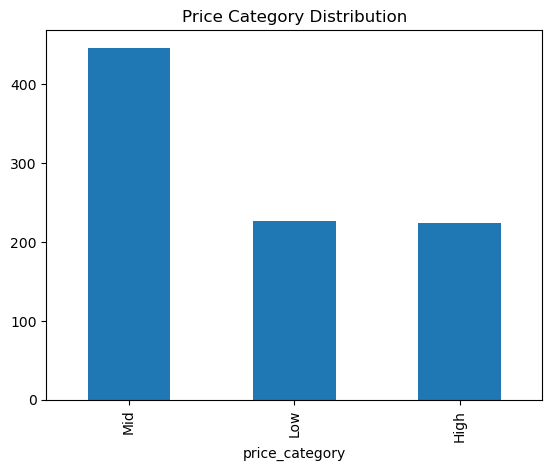

In [12]:
df['price_category'].value_counts().plot(kind='bar', title='Price Category Distribution')
plt.show()

In [13]:

bucket_mapping = {'Low': 0, 'Mid': 1, 'High': 2}

# Apply the mapping to the target column
df['price_category'] = df['price_category'].map(bucket_mapping)

# Verify the conversion
print(df['price_category'].head())


0    0
1    0
2    0
3    0
4    0
Name: price_category, dtype: category
Categories (3, int64): [0 < 1 < 2]


In [14]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np

categorical_columns = df.select_dtypes(include=['object']).columns

# Function to apply OrdinalEncoder
def apply_ordinal_encoding(X, categorical_columns):
    """
    Applies OrdinalEncoder to the categorical columns of a dataset and returns
    the encoded dataset along with the encoder for future use.
    """
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[categorical_columns] = encoder.fit_transform(X[categorical_columns].astype(str))  # Convert to string for consistency
    return X, encoder

df, ordinal_encoder = apply_ordinal_encoding(df.copy(), categorical_columns)

In [15]:
import joblib

# Save the encoder
joblib.dump(ordinal_encoder, "ordinal_encoder.pkl")

ordinal_encoder = joblib.load("ordinal_encoder.pkl")

In [16]:
X = df.drop(['price_category'], axis = 1)
y = df['price_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

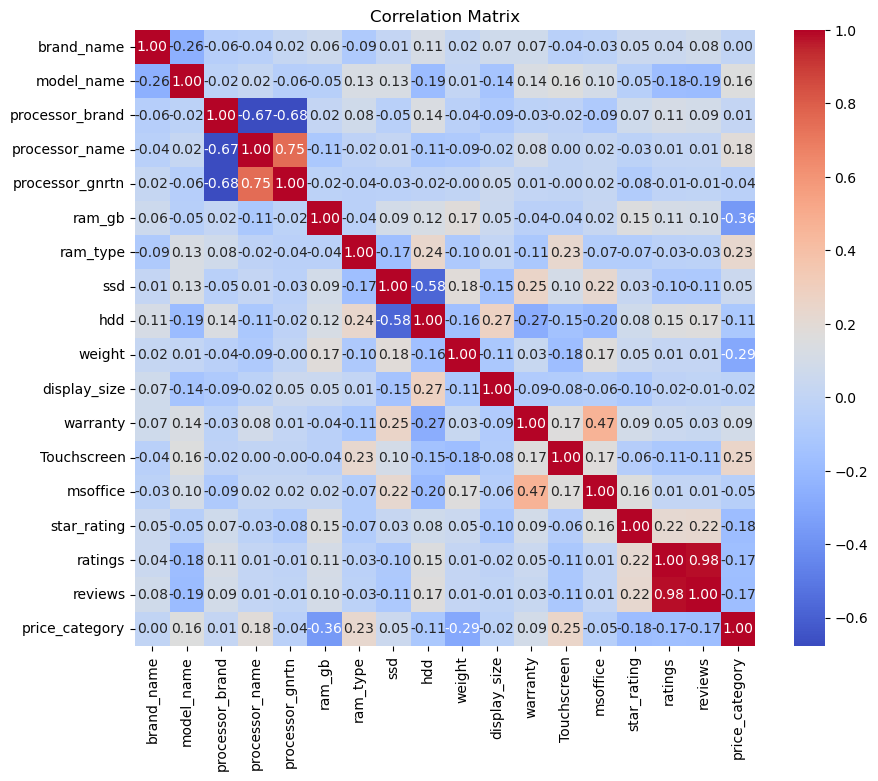

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64', 'category'])

# Correlation Matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


In [18]:
!pip install mlflow

In [19]:
import dagshub
import mlflow

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Define numerical and categorical columns
X_columns = X.columns

# Numerical Transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler( ))                   # Scale numerical features
])

# ColumnTransformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_columns)
    ]
)

In [21]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
ridge_model = RidgeClassifier(random_state=42)
random_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

In [22]:
dagshub.init(repo_owner='sreenathreddy6633', repo_name='laptop-price', mlflow=True)

Accessing as sreenathreddy6633

Initialized MLflow to track repo "sreenathreddy6633/laptop-price"

Repository sreenathreddy6633/laptop-price initialized!

In [23]:
# Pipeline with Preprocessor and Model
pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

In [24]:
mlflow.set_experiment('Experiment 1')
with mlflow.start_run(run_name='LogisticRegression'):
    # Fit the Pipeline
    pipeline_logistic.fit(X_train, y_train)

    # Evaluate the Model
    y_train_pred = pipeline_logistic.predict(X_train)
    y_test_pred = pipeline_logistic.predict(X_test)

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"Train F1 Score: {train_f1:.2f}")
    print(f"Test F1 Score: {test_f1:.2f}")

    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)

    # Log Model to MLflow
    mlflow.sklearn.log_model(pipeline_logistic, "logistic_regression_pipeline")
    train_score = pipeline_logistic.score(X_train, y_train)
    test_score = pipeline_logistic.score(X_test, y_test)

    print(f"Train Accuracy: {train_score:.2f}")
    print(f"Test Accuracy: {test_score:.2f}")

    # Log Metrics to MLflow
    mlflow.log_metric("train_accuracy", train_score)
    mlflow.log_metric("test_accuracy", test_score)

    # Log Model to MLflow
    mlflow.sklearn.log_model(pipeline_logistic, "logistic_regression_pipeline")

print("Experiment 1 complete.")

Train F1 Score: 0.69
Test F1 Score: 0.64


2024/12/21 13:30:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy: 0.69
Test Accuracy: 0.65


2024/12/21 13:30:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/1/runs/db4e0c768b334e99b3674b819babd38a
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/1
Experiment 1 complete.


# Experiment 2

In [26]:
# Define Classifiers
classifiers = {
    'LogisticRegression': logistic_model,
    'RidgeClassifier': ridge_model,
    'RandomForestClassifier': random_model,
    'XGBClassifier': xgb_model
}

In [27]:
# Set MLflow Tracking URI and Experiment
mlflow.set_experiment("Experiment 2")

for name, model in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create Pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        print(name)
        # Define Hyperparameter Grid
        if name == 'LogisticRegression':
            param_grid = {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l2'],
                'classifier__solver': ['lbfgs', 'liblinear']
            }
        elif name == 'RidgeClassifier':
            param_grid = {
                'classifier__alpha': [0.01, 0.1, 1, 10]
            }
        elif name == 'RandomForestClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [None, 10, 20]
            }
        elif name == 'XGBClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 10]
            }

        # GridSearchCV with StratifiedKFold
        grid_search = GridSearchCV(
            pipeline, param_grid,
            cv=StratifiedKFold(n_splits=10),
            scoring='f1_weighted', verbose=2, n_jobs=-1, return_train_score=True
        )

        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log Best Estimator and Parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{name} - Best Params:", best_params)
        mlflow.log_params(best_params)

        # Cross-Validation Results
        cv_results = cross_validate(
            best_pipeline, X_train, y_train, cv=10,
            scoring='f1_weighted', return_train_score=True
        )
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        mlflow.log_metric("mean_f1_cv", mean_f1)
        mlflow.log_metric("std_f1_cv", std_f1)

        # Fit Best Pipeline on Training Data
        best_pipeline.fit(X_train, y_train)

        # Evaluate on Train Data
        y_pred_train = best_pipeline.predict(X_train)
        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        train_cm = confusion_matrix(y_train, y_pred_train).ravel()
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_text(f"Train Confusion Matrix: {train_cm}", f"confusion_matrix/{name}_train_confusion_matrix.txt")

        # Evaluate on Test Data
        y_pred_test = best_pipeline.predict(X_test)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        test_cm = confusion_matrix(y_test, y_pred_test).ravel()
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_text(f"Test Confusion Matrix: {test_cm}", f"confusion_matrix/{name}_test_confusion_matrix.txt")

        # Save Model to MLflow
        mlflow.sklearn.log_model(best_pipeline, f"{name}_pipeline")

print("Experiment 2 execution and tracking complete.")

LogisticRegression
Fitting 10 folds for each of 8 candidates, totalling 80 fits
LogisticRegression - Best Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


2024/12/21 13:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2/runs/40ea9f8f74ce4743a36ad4e7fbd4dfc2
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2
RidgeClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits
RidgeClassifier - Best Params: {'classifier__alpha': 0.01}


2024/12/21 13:31:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2/runs/6c419ef29d1e4fb28e8658d1686267e6
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2
RandomForestClassifier
Fitting 10 folds for each of 9 candidates, totalling 90 fits
RandomForestClassifier - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}


2024/12/21 13:31:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2/runs/998fdfea3ce248b580f07f90263d9e37
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2
XGBClassifier
Fitting 10 folds for each of 27 candidates, totalling 270 fits
XGBClassifier - Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}


2024/12/21 13:31:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2/runs/9865607f385043b6a57be45bd2984c57
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/2
Experiment 2 execution and tracking complete.


# Experiment 3

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand_name       896 non-null    float64
 1   model_name       896 non-null    float64
 2   processor_brand  896 non-null    float64
 3   processor_name   896 non-null    float64
 4   processor_gnrtn  896 non-null    float64
 5   ram_gb           896 non-null    float64
 6   ram_type         896 non-null    float64
 7   ssd              896 non-null    float64
 8   hdd              896 non-null    float64
 9   weight           896 non-null    float64
 10  display_size     896 non-null    float64
 11  warranty         896 non-null    int64  
 12  Touchscreen      896 non-null    float64
 13  msoffice         896 non-null    float64
 14  star_rating      896 non-null    float64
 15  ratings          896 non-null    int64  
 16  reviews          896 non-null    int64  
dtypes: float64(14), 

In [30]:

# Define Feature Engineering Function
def feature_engineering(data):
    data['reactions'] = (data['ratings'] + data['reviews'])
    data['display_size'] = data['display_size'].apply(
        lambda x: str(x).replace('inch', '') if isinstance(x, str) else x
    )
    data['display_size'] = pd.to_numeric(data['display_size'], errors='coerce')
    data['display_size'] = data['display_size'].fillna(data['display_size'].median())  # Impute with median

    data['warranty_importance'] = data['warranty'] * data['msoffice'].apply(lambda x: 1 if x == 'Yes' else 0)
    return data
    

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)


numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [31]:


# Set MLflow Tracking URI and Experiment
mlflow.set_experiment("Experiment 3")

for name, model in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create Pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        print(name)
        # Define Hyperparameter Grid
        if name == 'LogisticRegression':
            param_grid = {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l2'],
                'classifier__solver': ['lbfgs', 'liblinear']
            }
        elif name == 'RidgeClassifier':
            param_grid = {
                'classifier__alpha': [0.01, 0.1, 1, 10]
            }
        elif name == 'RandomForestClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [None, 10, 20]
            }
        elif name == 'XGBClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 10]
            }

        # GridSearchCV with StratifiedKFold
        grid_search = GridSearchCV(
            pipeline, param_grid,
            cv=StratifiedKFold(n_splits=10),
            scoring='f1_weighted', verbose=2, n_jobs=-1, return_train_score=True
        )

        # Fit GridSearchCV
        grid_search.fit(X_train_fe, y_train)

        # Log Best Estimator and Parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{name} - Best Params:", best_params)
        mlflow.log_params(best_params)

        # Cross-Validation Results
        cv_results = cross_validate(
            best_pipeline, X_train_fe, y_train, cv=10,
            scoring='f1_weighted', return_train_score=True
        )
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        mlflow.log_metric("mean_f1_cv", mean_f1)
        mlflow.log_metric("std_f1_cv", std_f1)

        # Fit Best Pipeline on Training Data
        best_pipeline.fit(X_train_fe, y_train)

        # Evaluate on Train Data
        y_pred_train = best_pipeline.predict(X_train_fe)
        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        train_cm = confusion_matrix(y_train, y_pred_train).ravel()
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_text(f"Train Confusion Matrix: {train_cm}", f"confusion_matrix/{name}_train_confusion_matrix.txt")

        # Evaluate on Test Data
        y_pred_test = best_pipeline.predict(X_test_fe)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        test_cm = confusion_matrix(y_test, y_pred_test).ravel()
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_text(f"Test Confusion Matrix: {test_cm}", f"confusion_matrix/{name}_test_confusion_matrix.txt")

        # Save Model to MLflow
        mlflow.sklearn.log_model(best_pipeline, f"{name}_pipeline")

print("Experiment 3 execution and tracking complete.")


LogisticRegression
Fitting 10 folds for each of 8 candidates, totalling 80 fits
LogisticRegression - Best Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


2024/12/21 13:32:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3/runs/781d01f7c5734fd3b3f1b930b493fbc3
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3
RidgeClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits
RidgeClassifier - Best Params: {'classifier__alpha': 0.01}


2024/12/21 13:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3/runs/9ec798ec2cc647b0af81e03e79233d75
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3
RandomForestClassifier
Fitting 10 folds for each of 9 candidates, totalling 90 fits
RandomForestClassifier - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}


2024/12/21 13:32:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3/runs/9385912328974a6cb533ac6d06175d6a
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3
XGBClassifier
Fitting 10 folds for each of 27 candidates, totalling 270 fits
XGBClassifier - Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}


2024/12/21 13:32:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3/runs/7265763901594eb281cdf002027adaa5
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/3
Experiment 3 execution and tracking complete.


# Experiment 4

In [33]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif

def feature_selection(X, y, threshold=0.01, corr_threshold=0.9, k_best=7):
    # Ensure the input X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        raise ValueError("Input X must be a pandas DataFrame")

    # Variance Threshold
    variance_selector = VarianceThreshold(threshold=threshold)
    X_var = variance_selector.fit_transform(X)  # Apply variance threshold
    selected_variance_features = X.columns[variance_selector.get_support()].tolist()

    # Correlation Threshold
    correlation_matrix = pd.DataFrame(X_var, columns=selected_variance_features).corr().abs()
    upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1)

    # Identify highly correlated features
    correlated_features = [
        correlation_matrix.columns[i]
        for i in range(len(correlation_matrix.columns))
        for j in range(i + 1, len(correlation_matrix.columns))
        if correlation_matrix.iloc[i, j] > corr_threshold
    ]

    # Remove correlated features
    selected_correlation_features = [
        feature for feature in selected_variance_features if feature not in correlated_features
    ]

    # Feature Importance
    feature_importance_selector = SelectKBest(score_func=mutual_info_classif, k=min(k_best, len(selected_correlation_features)))
    X_important = feature_importance_selector.fit_transform(X[selected_correlation_features], y)
    selected_important_features = np.array(selected_correlation_features)[feature_importance_selector.get_support()].tolist()

    return selected_important_features

In [34]:
# Apply Feature Selection

preprocessor_1 = Pipeline([
    ("scaler", StandardScaler())
])
pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier', logistic_model)
])

selected_features = feature_selection(X_train, y_train)

print("Selected Features:", selected_features) 

X_train_fs = X_train[selected_features]
X_test_fs = X_test[selected_features]
# Set MLflow Tracking URI and Experiment
mlflow.set_experiment("Experiment 4")

with mlflow.start_run(run_name = 'LogisticRegression'):
    # Fit the Pipeline
    pipeline_logistic.fit(X_train_fs, y_train)
    
    # Predict and Evaluate
    y_train_pred = pipeline_logistic.predict(X_train_fs)
    y_test_pred = pipeline_logistic.predict(X_test_fs)

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"Train F1 Score: {train_f1:.2f}")
    print(f"Test F1 Score: {test_f1:.2f}")

    # Log Metrics
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)

    # Log Feature Selection Details
    mlflow.log_text(
        f"Selected Features: {selected_features}",
        "feature_selection_details.txt"
    )

    # Log Model
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline")

print("Experiment 4 complete and results logged in MLflow.")

Selected Features: ['model_name', 'processor_name', 'ram_gb', 'ssd', 'display_size', 'star_rating', 'reactions']
Train F1 Score: 0.62
Test F1 Score: 0.58


2024/12/21 13:33:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/4/runs/cb27189c1ed44478897eb89a97cb6711
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/4
Experiment 4 complete and results logged in MLflow.


# Experiment 5

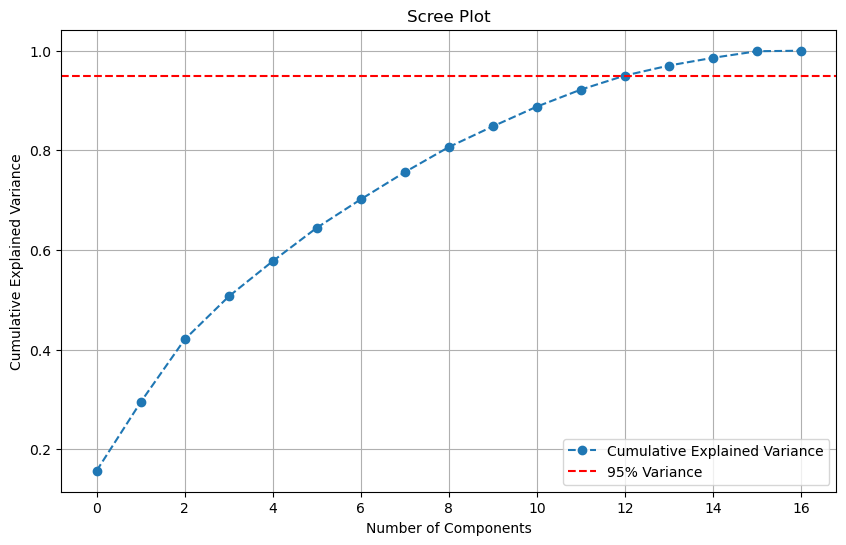

Number of components explaining 95% variance: 13
Train Accuracy: 0.66
Test Accuracy: 0.62


In [36]:
# Define PCA
pca = PCA()

# Pipeline for Preprocessing and PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('pca', pca),                    # Perform PCA
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression
])

# Fit Preprocessing and PCA on the Training Set
pipeline.named_steps['preprocessor'].fit(X_train)  # Fit the preprocessor
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)  # Transform X_train
pca.fit(X_train_transformed)  # Fit PCA on transformed data

# Scree Plot for Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_  # Extract explained variance ratios
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')  # Highlight 95% threshold
plt.legend()
plt.grid()
plt.show()

# Select the Number of Components Explaining 95% Variance
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1  # Add 1 because indexing starts at 0
print(f"Number of components explaining 95% variance: {n_components}")

# Update Pipeline with the Selected Number of Components
pipeline_logistic_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),        # Use the same preprocessing step
    ('pca', PCA(n_components=n_components)),  # Use only the selected components
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression
])

# Fit the Final Pipeline
pipeline_logistic_pca.fit(X_train, y_train)

# Evaluate the Pipeline
train_score = pipeline_logistic_pca.score(X_train, y_train)
test_score = pipeline_logistic_pca.score(X_test, y_test)

print(f"Train Accuracy: {train_score:.2f}")
print(f"Test Accuracy: {test_score:.2f}")

In [37]:

mlflow.set_experiment("Experiment 5")

for name, model in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create Pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=n_components)),
            ('classifier', model)
        ])
        print(name)
        # Define Hyperparameter Grid
        if name == 'LogisticRegression':
            param_grid = {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l2'],
                'classifier__solver': ['lbfgs', 'liblinear']
            }
        elif name == 'RidgeClassifier':
            param_grid = {
                'classifier__alpha': [0.01, 0.1, 1, 10]
            }
        elif name == 'RandomForestClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [None, 10, 20]
            }
        elif name == 'XGBClassifier':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 10]
            }

        # GridSearchCV with StratifiedKFold
        grid_search = GridSearchCV(
            pipeline, param_grid,
            cv=StratifiedKFold(n_splits=10),
            scoring='f1_weighted', verbose=2, n_jobs=-1, return_train_score=True
        )

        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log Best Estimator and Parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{name} - Best Params:", best_params)
        mlflow.log_params(best_params)

        # Cross-Validation Results
        cv_results = cross_validate(
            best_pipeline, X_train, y_train, cv=10,
            scoring='f1_weighted', return_train_score=True
        )
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        mlflow.log_metric("mean_f1_cv", mean_f1)
        mlflow.log_metric("std_f1_cv", std_f1)

        # Fit Best Pipeline on Training Data
        best_pipeline.fit(X_train, y_train)

        # Evaluate on Train Data
        y_pred_train = best_pipeline.predict(X_train)
        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        train_cm = confusion_matrix(y_train, y_pred_train).ravel()
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_text(f"Train Confusion Matrix: {train_cm}", f"confusion_matrix/{name}_train_confusion_matrix.txt")

        # Evaluate on Test Data
        y_pred_test = best_pipeline.predict(X_test)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        test_cm = confusion_matrix(y_test, y_pred_test).ravel()
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_text(f"Test Confusion Matrix: {test_cm}", f"confusion_matrix/{name}_test_confusion_matrix.txt")

        # Save Model to MLflow
        mlflow.sklearn.log_model(best_pipeline, f"{name}_pipeline")

print("Experiment 5 execution and tracking complete.")

LogisticRegression
Fitting 10 folds for each of 8 candidates, totalling 80 fits
LogisticRegression - Best Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


2024/12/21 13:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5/runs/2e2838c2f47e4ec3a1aad923383879bd
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5
RidgeClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits
RidgeClassifier - Best Params: {'classifier__alpha': 0.01}


2024/12/21 13:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5/runs/062ae2c712f1484b808759ed7dea6aee
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5
RandomForestClassifier
Fitting 10 folds for each of 9 candidates, totalling 90 fits
RandomForestClassifier - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}


2024/12/21 13:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5/runs/63dcb15e1dcf4822ad234d018afd43d1
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5
XGBClassifier
Fitting 10 folds for each of 27 candidates, totalling 270 fits
XGBClassifier - Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}


2024/12/21 13:34:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5/runs/3e87e88d1b3346139ce9ea49261cb168
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/5
Experiment 5 execution and tracking complete.


# Experiment 6

In [39]:
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score
# Define numerical columns
numerical_columns = X_train.columns  # Assuming all columns are numerical


# Define SVC model
svc_model = SVC(kernel='rbf', probability=True, random_state=42)

# Pipeline
pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svc_model)
])

param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001], 
    'classifier__kernel': ['rbf']  # Radial basis function kernel
}

grid_search = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Set MLFlow Experiment
mlflow.set_experiment("Experiment 6")

with dagshub.dagshub_logger() as logger:
    with mlflow.start_run(run_name="SVC Model"):
        # Train the model with GridSearchCV
        grid_search.fit(X_train, y_train)

        # Best parameters and best model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        print(f"Best Parameters: {best_params}")

        # Predict on training and test sets
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Evaluate the model
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        # Log parameters, metrics, and model
        mlflow.log_params(best_params)
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)

        logger.log_metrics({
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1
        })

        # Log the model
        mlflow.sklearn.log_model(best_model, "svc_model")
        print(f"SVC Model - Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"SVC Model - Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

print("SVC model training and logging complete.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'classifier__C': 100, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}


2024/12/21 13:34:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC Model - Train Accuracy: 0.8883, Train F1: 0.8880
SVC Model - Test Accuracy: 0.7611, Test F1: 0.7608
🏃 View run SVC Model at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/9/runs/683e21d5ff4b4384b81f36be708f08e1
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/9
SVC model training and logging complete.


# Experiment 7

In [41]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

base_models = [
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)


mlflow.set_experiment("Experiment 7")

with dagshub.dagshub_logger() as logger:
    with mlflow.start_run(run_name="Stacking Model"):
        # Train the stacking model
        stacking_clf.fit(X_train, y_train)

        # Make predictions
        y_train_pred = stacking_clf.predict(X_train)
        y_test_pred = stacking_clf.predict(X_test)

        # Evaluate the model
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        # Log metrics
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)

        logger.log_metrics({
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1
        })

        # Log the model
        mlflow.sklearn.log_model(stacking_clf, "stacking_model")

        # Print results
        print(f"Stacking Model - Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Stacking Model - Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

print("Stacking model training and logging complete.")

2024/12/21 13:34:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Stacking Model - Train Accuracy: 0.9846, Train F1: 0.9846
Stacking Model - Test Accuracy: 0.8722, Test F1: 0.8725
🏃 View run Stacking Model at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/10/runs/503ff57dc8a9447eaaff0cfbe64bb0a9
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/laptop-price.mlflow/#/experiments/10
Stacking model training and logging complete.


,brand_name,model_name,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,weight,display_size,warranty,Touchscreen,msoffice,star_rating,ratings,reviews,reactions,warranty_importance
806,4.0,85.0,0.0,24.0,7.0,2.0,1.0,4.0,1.0,0.0,15.0,0,0.0,0.0,0.0,0,0,0,0
177,2.0,69.0,1.0,5.0,1.0,3.0,1.0,0.0,1.0,0.0,10.0,0,0.0,0.0,3.0,4,0,4,0
505,2.0,69.0,1.0,6.0,0.0,3.0,1.0,4.0,1.0,0.0,15.0,0,0.0,0.0,5.0,1,1,2,0
139,2.0,103.0,1.0,5.0,0.0,2.0,1.0,7.0,0.0,0.0,15.0,1,0.0,0.0,4.4,4008,519,4527,0
614,5.0,54.0,1.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1,0.0,1.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,2.0,111.0,1.0,6.0,1.0,3.0,5.0,7.0,0.0,0.0,15.0,1,1.0,0.0,0.0,0,0,0,0
13,2.0,37.0,1.0,6.0,0.0,3.0,1.0,7.0,0.0,0.0,15.0,0,0.0,0.0,0.0,0,0,0,0
457,17.0,16.0,1.0,6.0,1.0,3.0,1.0,0.0,1.0,2.0,4.0,1,0.0,0.0,3.8,253,28,281,0
260,2.0,103.0,1.0,6.0,0.0,3.0,1.0,7.0,0.0,0.0,10.0,1,0.0,0.0,4.0,35,2,37,0


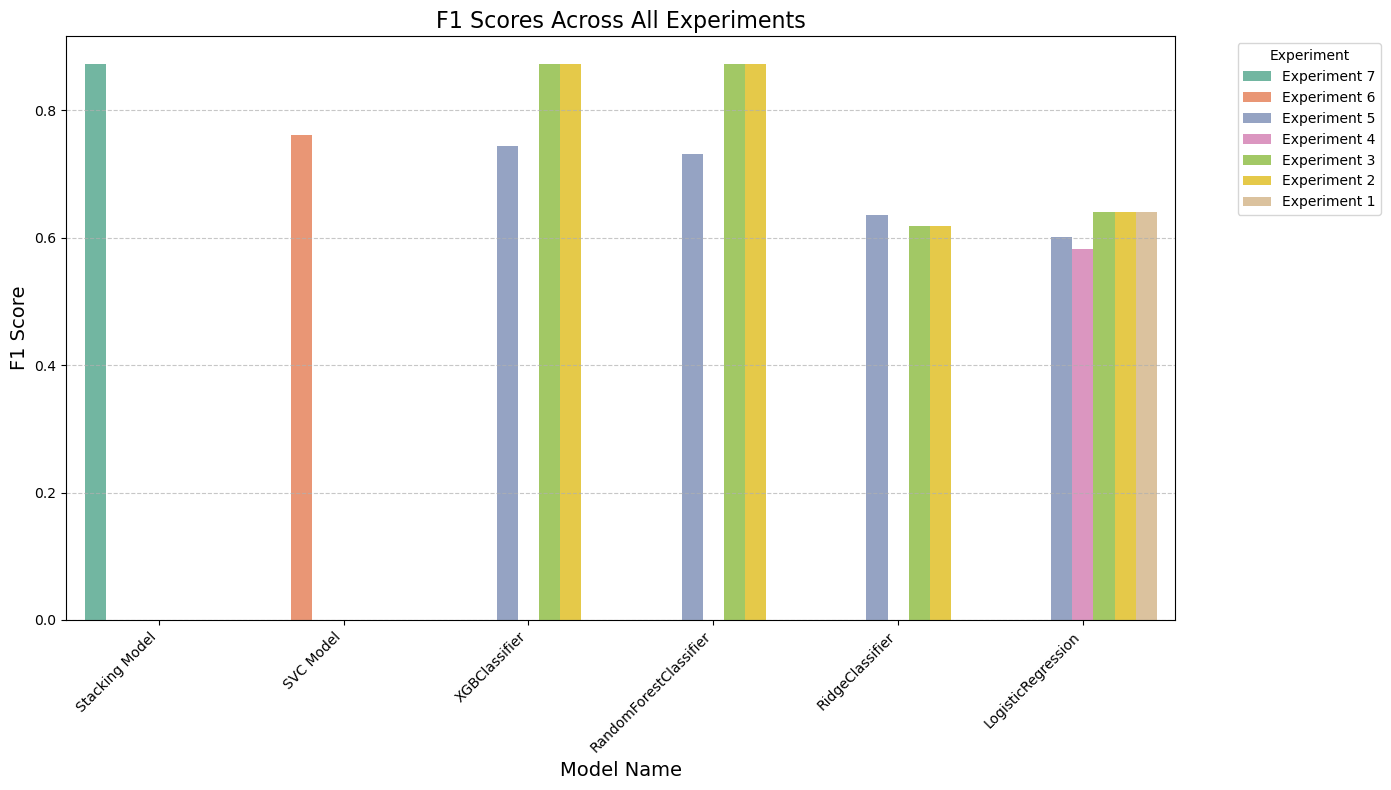

In [43]:
# Fetch all experiments
experiments = mlflow.search_experiments()
experiment_ids = [exp.experiment_id for exp in experiments]

# Collect all F1 scores
all_f1_scores = []

for experiment_id in experiment_ids:
    # Get runs for each experiment
    experiment_name = mlflow.get_experiment(experiment_id).name
    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    
    for _, run in runs.iterrows():
        # Check if F1 score is logged
        if 'metrics.test_f1' in run:
            all_f1_scores.append({
                'Experiment': experiment_name,
                'Model Name': run['tags.mlflow.runName'] if 'tags.mlflow.runName' in run else 'Unknown',
                'F1 Score': run['metrics.test_f1']
            })

# Convert to DataFrame
f1_scores_df = pd.DataFrame(all_f1_scores)

# Plot F1 Scores as Bar Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=f1_scores_df, 
    x='Model Name', 
    y='F1 Score', 
    hue='Experiment', 
    palette='Set2'
)

plt.title('F1 Scores Across All Experiments', fontsize=16)
plt.xlabel('Model Name', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [92]:

encoder = joblib.load("ordinal_encoder.pkl") 


# Combine Encoder and Model in a Pipeline
pipeline = Pipeline(steps=[
    ('encoder', encoder),
    ('classifier', stacking_clf)
])

# Train the Pipeline (ensure you fit the model with preprocessed data)
pipeline.fit(X_train, y_train)  # Replace with your training data

# Save the Pipeline as joblib
joblib.dump(pipeline, "final_model_pipeline.joblib")
print("Pipeline with encoder and model saved as 'final_model_pipeline.joblib'.")

# --------------------------
# Loading and Using the Pipeline in Production
# --------------------------

# Load the Pipeline
loaded_pipeline = joblib.load("final_model_pipeline.joblib")

# Predict on new data

predictions = loaded_pipeline.predict(X_test)

print("Predictions:", predictions)


Pipeline with encoder and model saved as 'final_model_pipeline.joblib'.
Predictions: [0 1 1 1 0 0 1 2 1 1 0 0 1 0 1 0 2 1 0 0 2 2 1 1 1 1 1 1 2 1 1 2 2 1 2 0 1
 0 1 1 1 2 2 2 0 0 0 2 1 1 1 1 2 0 0 0 1 2 0 2 1 1 2 2 2 1 1 1 1 1 0 2 0 2
 2 1 1 2 2 1 2 1 1 0 1 0 1 1 1 1 0 0 2 2 1 1 2 2 2 1 0 1 1 1 2 0 2 1 0 1 2
 2 1 2 0 1 1 0 1 1 1 1 2 1 2 1 0 0 0 0 1 2 2 2 0 1 0 2 1 1 0 2 1 1 0 2 1 1
 0 1 1 2 1 0 0 2 0 0 2 0 1 2 2 1 1 0 2 2 1 1 2 0 0 1 0 0 1 2 2 1]
0.8888888888888888


In [98]:
X_test.columns

Index(['brand_name', 'model_name', 'processor_brand', 'processor_name',
       'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'weight',
       'display_size', 'warranty', 'Touchscreen', 'msoffice', 'star_rating',
       'ratings', 'reviews', 'reactions', 'warranty_importance'],
      dtype='object')

In [12]:
df_test = pd.read_csv('Cleaned_Laptop_data.csv')
for col in df_test.columns:
    print(col)
    print(df_test[col].unique())

brand
['Lenovo' 'Avita' 'HP' 'acer' 'ASUS' 'DELL' 'RedmiBook' 'realme' 'Infinix'
 'MSI' 'lenovo' 'MICROSOFT' 'Smartron' 'LG' 'Nokia' 'APPLE' 'Vaio' 'Mi'
 'ALIENWARE' 'iball' 'SAMSUNG']
model
['A6-9225' 'Ideapad' 'PURA' 'APU' 'Athlon' 'Aspire' 'ExpertBook' 'Missing'
 'v15' 'VivoBook' 'EeeBook' 'Nitro' 'Cosmos' 'x360' 'IdeaPad' 'Celeron'
 '15q' '250-G6' 'Vostro' '15' 'Pavilion' 'Book' 'Inspiron' 'INBook'
 'ThinkPad' 'Chromebook' 'Commercial' '14s' 'INSPIRON' 'V15' '15s' '3000'
 'Notebook' 'Vivo' 'DA' 'Insprion' 'Travelmate' '14a' 'Predator' 'Spin'
 'Swift' 'ROG' 'XPS' 'Omen' 'Surface' 't.book' 'Yoga' 'Gram' 'Spectre'
 'VivoBook14' 'TUF' 'Book(Slim)' 'Pro' 'PureBook' 'ASUS' 'Katana' 'GF63'
 'Thinkbook' 'Intel' 'G15' 'ZenBook' 'Legion' 'Modern' 'ThinkBook'
 'Prestige' 'Zenbook' 'MacBook' 'Sword' 'Envy' 'SE' 'ConceptD' 'HP' 'DELL'
 'X390' 'Thinpad' 'Inpiron' 'GAMING' 'GS' '430' 'Liber' 'F17' 'B50-70'
 'GE76' 'GP65' 'GP76' '250' '3511' 'G3' 'GS66' 'X1' 'GF65' 'Stealth'
 'Zephyrus' 'Summit' '

In [ ]:
['Lenovo' 'Avita' 'HP' 'acer' 'ASUS' 'DELL' 'RedmiBook' 'realme' 'Infinix'
 'MSI' 'lenovo' 'MICROSOFT' 'Smartron' 'LG' 'Nokia' 'APPLE' 'Vaio' 'Mi'
 'ALIENWARE' 'iball' 'SAMSUNG']

['A6-9225' 'Ideapad' 'PURA' 'APU' 'Athlon' 'Aspire' 'ExpertBook' 'Missing'
 'v15' 'VivoBook' 'EeeBook' 'Nitro' 'Cosmos' 'x360' 'IdeaPad' 'Celeron'
 '15q' '250-G6' 'Vostro' '15' 'Pavilion' 'Book' 'Inspiron' 'INBook'
 'ThinkPad' 'Chromebook' 'Commercial' '14s' 'INSPIRON' 'V15' '15s' '3000'
 'Notebook' 'Vivo' 'DA' 'Insprion' 'Travelmate' '14a' 'Predator' 'Spin'
 'Swift' 'ROG' 'XPS' 'Omen' 'Surface' 't.book' 'Yoga' 'Gram' 'Spectre'
 'VivoBook14' 'TUF' 'Book(Slim)' 'Pro' 'PureBook' 'ASUS' 'Katana' 'GF63'
 'Thinkbook' 'Intel' 'G15' 'ZenBook' 'Legion' 'Modern' 'ThinkBook'
 'Prestige' 'Zenbook' 'MacBook' 'Sword' 'Envy' 'SE' 'ConceptD' 'HP' 'DELL'
 'X390' 'Thinpad' 'Inpiron' 'GAMING' 'GS' '430' 'Liber' 'F17' 'B50-70'
 'GE76' 'GP65' 'GP76' '250' '3511' 'G3' 'GS66' 'X1' 'GF65' 'Stealth'
 'Zephyrus' 'Summit' 'OMEN' 'Pulse' 'WF65' 'Creator' 'Dual' 'G7'
 'CompBook' 'Pentium' 'Extensa' 'Asus' 'Ryzen' 'Bravo' '15-ec1105AX' 'G5'
 'E' 'AMD' 'IDEAPAD' 'Lenovo' 'Alpha' 'Delta' 'Rog' 'Galaxy' 'Thinkpad']

